# Testing thresholds for calling mQTL
There are two methods I'm looking at by which mQTL are called, and I'm exploring them here:
1. A staged method as in [Oliva et al, 2020](https://doi.org/10.1126/science.aba3066)
    1. First take bonferroni corrected threshold to take into account the number of independent mQTL tested per CpG site
    1. Next compute the storey *qvalue* across CpG sites to identify CpG with at least one significant mQTL at an FDR of <= 0.25
1. Adaptive Groupwise BH FDR method as shown in [Sankaran and Holmes 2014](https://pubmed.ncbi.nlm.nih.gov/26917999/) and as described in [Hu, Zhao, and Zhou, 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3175141/)
    1. First estimate $\pi_{0,g}$, or the proportion of true NULL hypotheses in each group
        1. There are a few ways to estimate this, the least-slope method (LSL) which works well when signals are sparse and has nice empirical properties (quoting here from above 2010 paper)
        1. Two-Stage method which was shown in this paper to be consistent, as was LSL
    1. Reweight P-values by $\pi_{g,0}$, and reject $k$ hypotheses ranking weighted hypotheses $P^{W}_{(i)}$ such that 

$$k = \text{max} \Bigg\{ i: P^{W}_{(i)} \leq \frac{i\alpha^W}{N}\Bigg\}, \text{where } \alpha^W = \frac{\alpha}{1 - \pi_0} \text{and } \pi_0 = \frac{1}{N} \sum_{g=1}^K n_g \pi_{g,0} $$

In [1]:
library(data.table)
library(qvalue)
library(here)
library(structSSI)

here() starts at /scratch/st-dennisjk-1/wcasazza/sex_specific_mQTL



## Testing on marginal data
### Staged method

In [ ]:
meta_marginal < -fread(here("data", "delahaye_richs_marginal_mecs_maf01.txt.gz"))

In [3]:
meta_marginal_bonf_cpg <- meta_marginal[,.SD[p < (0.05 / .N)],by="Probe"]
meta_marginal_bonf_cpg <- meta_marginal_bonf_cpg[,.SD[which.min(p)],by="Probe"]

[1] 1.384045e-05

[1] 1

Warning message in min(lambda):
“no non-missing arguments to min; returning Inf”
Warning message in max(lambda):
“no non-missing arguments to max; returning -Inf”
Warning message in max(lambda):
“no non-missing arguments to max; returning -Inf”
Warning message in min(lambda):
“no non-missing arguments to min; returning Inf”
Warning message in max(pi0):
“no non-missing arguments to max; returning -Inf”
Warning message in min(pi0):
“no non-missing arguments to min; returning Inf”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


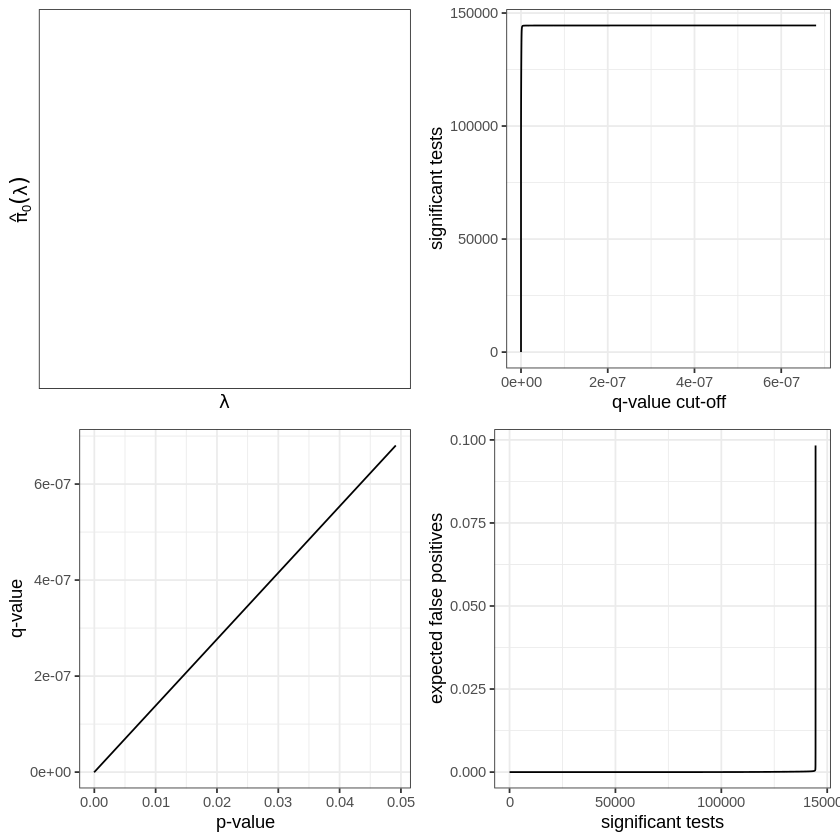

Warning message in min(lambda):
“no non-missing arguments to min; returning Inf”
Warning message in max(lambda):
“no non-missing arguments to max; returning -Inf”
Warning message in max(lambda):
“no non-missing arguments to max; returning -Inf”
Warning message in min(lambda):
“no non-missing arguments to min; returning Inf”
Warning message in max(pi0):
“no non-missing arguments to max; returning -Inf”
Warning message in min(pi0):
“no non-missing arguments to min; returning Inf”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


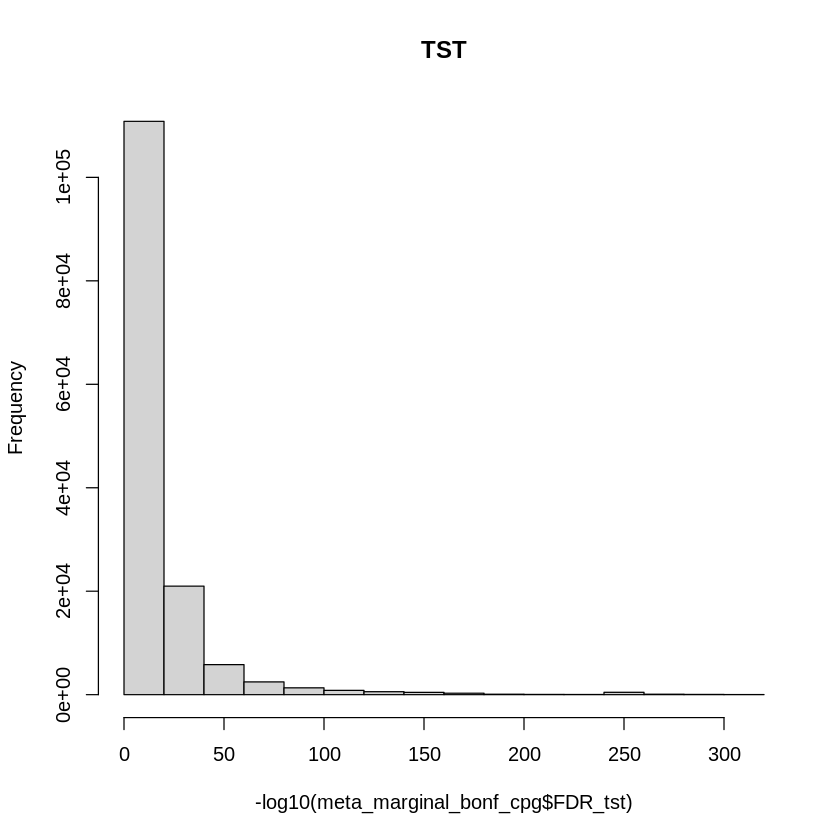

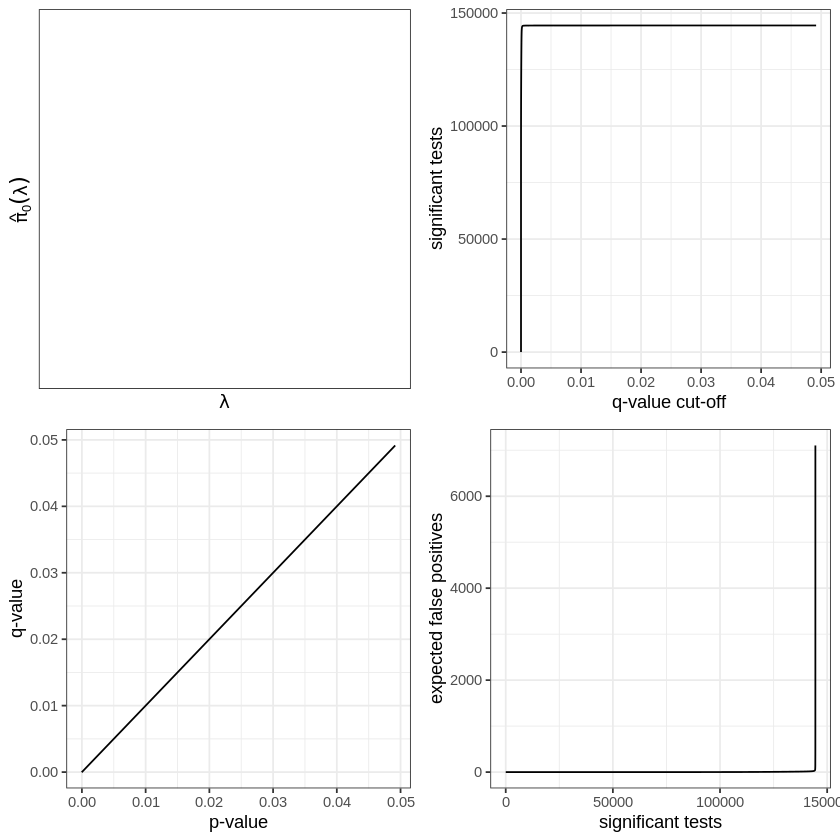

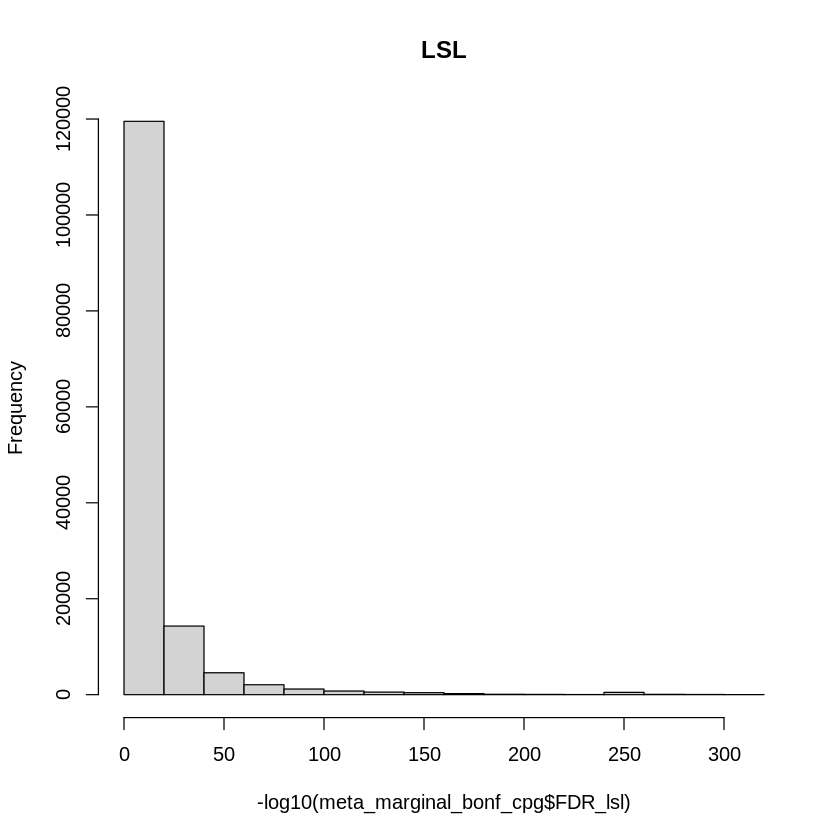

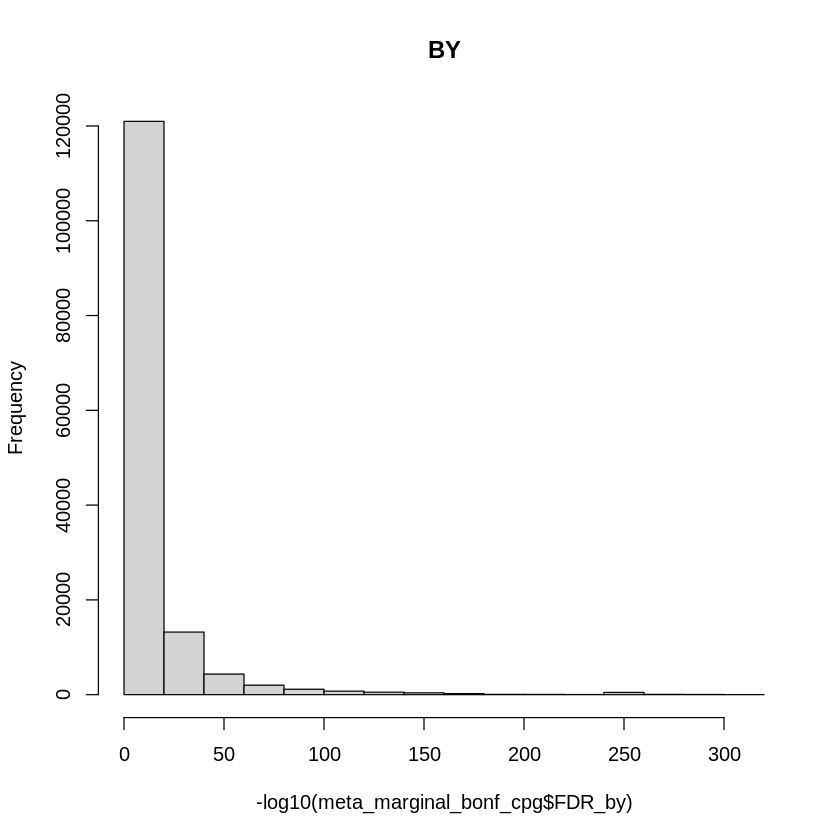

In [6]:
qval_tst <- qvalue(meta_marginal_bonf_cpg$p,pi0=estimate.pi0(meta_marginal_bonf_cpg$p,method = "tst"))
qval_lsl <- qvalue(meta_marginal_bonf_cpg$p,pi0=estimate.pi0(meta_marginal_bonf_cpg$p,method = "lsl"))

meta_marginal_bonf_cpg$FDR_tst <- qval_tst$qvalues
meta_marginal_bonf_cpg$FDR_lsl <- qval_lsl$qvalues
meta_marginal_bonf_cpg$FDR_by <- p.adjust(meta_marginal_bonf_cpg$p,method="BY")

estimate.pi0(meta_marginal_bonf_cpg$p,method = "tst")
estimate.pi0(meta_marginal_bonf_cpg$p,method = "lsl")

plot(qval_tst)
hist(-log10(meta_marginal_bonf_cpg$FDR_tst), main = "TST")
plot(qval_lsl)
hist(-log10(meta_marginal_bonf_cpg$FDR_lsl), main = "LSL")
hist(-log10(meta_marginal_bonf_cpg$FDR_by), main = "BY")

In [7]:
dim(meta_marginal_bonf_cpg)
dim(meta_marginal_bonf_cpg[FDR_tst < 0.05])
dim(meta_marginal_bonf_cpg[FDR_lsl < 0.05])
dim(meta_marginal_bonf_cpg[FDR_by < 0.05])
fwrite(meta_marginal_bonf_cpg[FDR_by < 0.05],here("data","meta_marginal_bonf_cpg.txt.gz"),sep='\t',quote=FALSE,row.names=FALSE)

[1] 144504     17

[1] 144504     17

[1] 144504     17

[1] 144490     17

###  Groupwise FDR

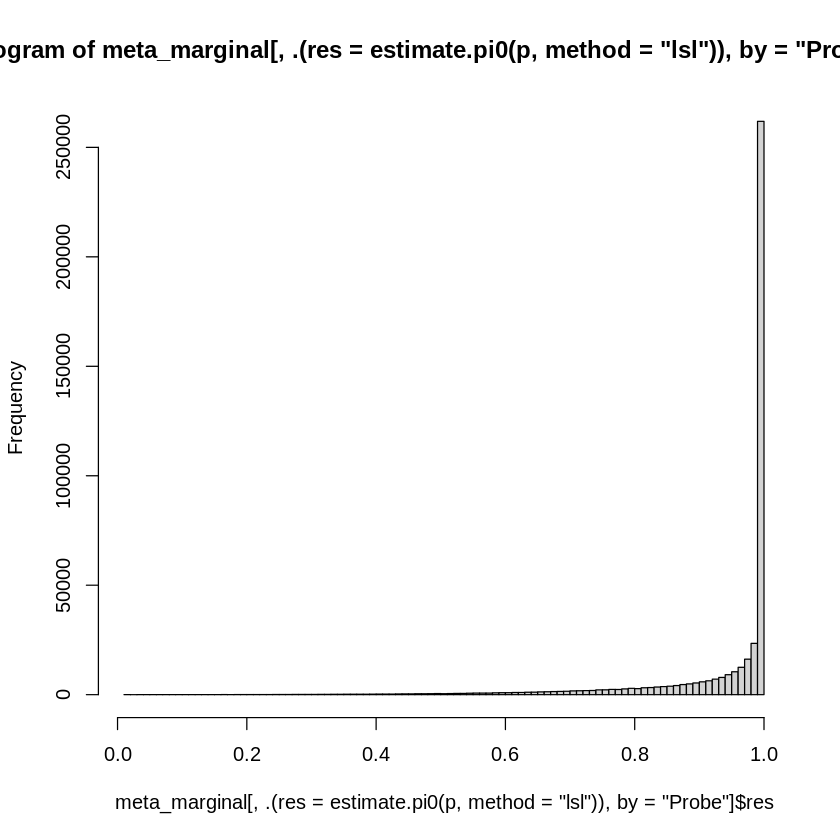

In [8]:
hist(meta_marginal[,.(res=estimate.pi0(p,method='lsl')), by="Probe"]$res,breaks = 100)
# hist(meta_marginal[,.(res=estimate.pi0(p,method='tst')), by="Probe"]$res,breaks = 100) # Returns NA for this data

In [8]:
adaptiveGBH <- function(dt,method,groupcol){
    # for a data.table with column p and grouping factor groupcol perform the adaptive Groupwise FDR procedure
    # adds a column adjP with adjusted P values, group pi_g pi0 values,
    dt <- na.omit(dt)
    dt[ ,`:=`(pi_g=estimate.pi0(p,method='lsl')), by = groupcol]
    dt[ ,`:=`(p_weighted=p* (pi_g / (1 - pi_g)))]
    pi0 <- sum(dt[,.(res = .N * unique(pi_g)),by=groupcol]$res) /nrow(dt)
    dt <- na.omit(dt)
    setorder(dt,p_weighted)
    if(pi0 < 1){
        dt[,`:=`(adjP=(nrow(dt) * (1 - pi0) * p_weighted) / (1:nrow(dt)))]
    }else{
        dt[,`:=`(adjP=p_weighted)]
    }
    # step up procedure for converting weighted values
    print(pi0)
    running_min <- dt$adjP[nrow(dt)]
    for(i in nrow(dt):1){ 
        if(dt$adjP[i] > running_min){
            set(dt,i=i,j="adjP",value=running_min)
        }else{
            running_min <- dt$adjP[i]
        }
    }
    dt[,`:=`(adjP= ifelse(adjP > 1,1,adjP))]
    return(dt)
}

In [3]:
out < -adaptiveGBH(meta_marginal, method="lsl", groupcol="Probe")
fwrite(out, "tmp_fdr_marginal_meta.csv")

[1] 0.9361095


V1,V2,N
<int>,<int>,<int>
3598236,179661,13892522


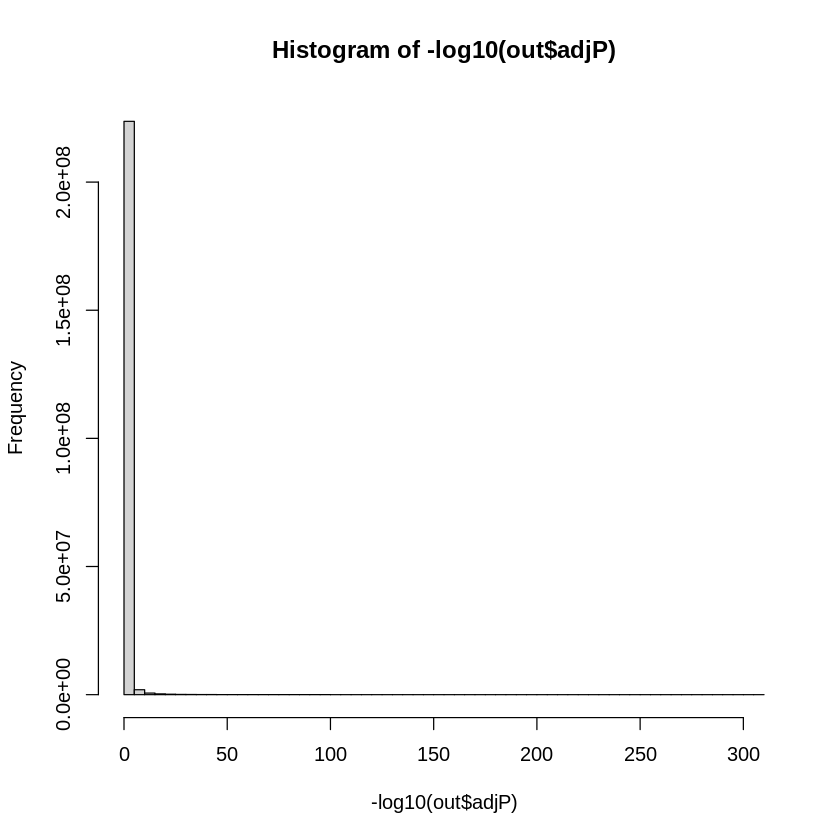

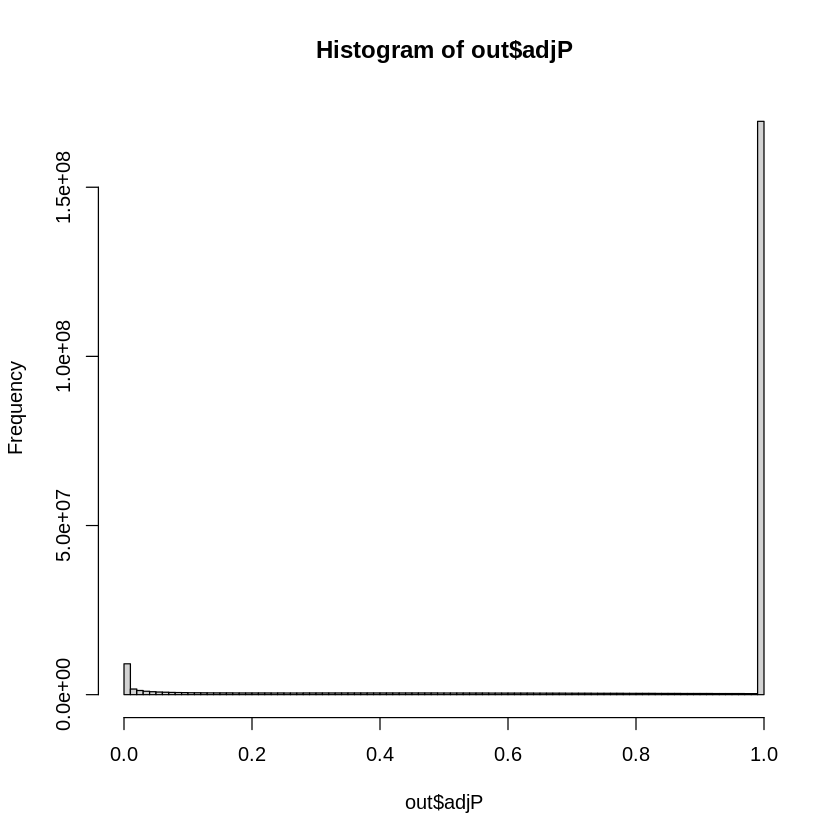

SNP,Chr,BP,A1,A2,Freq,Probe,Probe_Chr,Probe_bp,Gene,Orientation,b,SE,p,pi_g,p_weighted,adjP
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs62396080,6,26538276,T,C,0.0126571,cg11502198,6,26597334,cg11502198,+,0.000964817,0.064805,0.988122,0.02540416,0.02575673,0.03086231


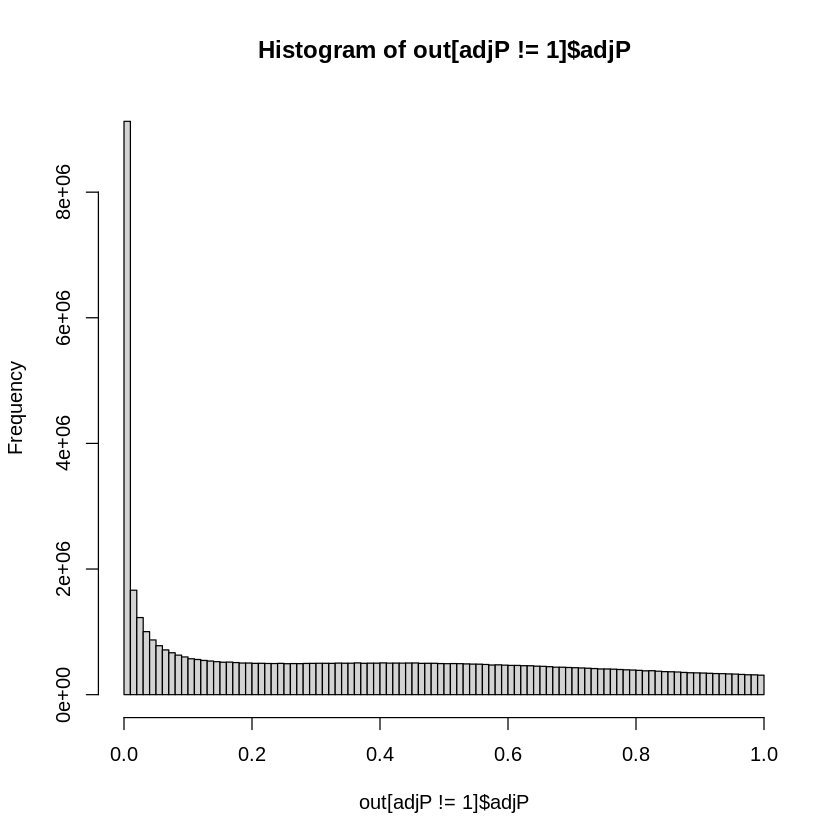

In [8]:
out[adjP < 0.05,.(uniqueN(SNP),uniqueN(Probe),.N)]
hist(-log10(out$adjP),breaks=100)
hist(out$adjP,breaks=100)
hist(out[adjP != 1]$adjP,breaks=100)
out[adjP < 0.05,.SD[which.max(p)]]

## Point of reference: Flat FDR and Bonferoni Correction


In [9]:
meta_marginal[,`:=`(
    FDR_bh= p.adjust(p,method = "BH"),
    FDR_by= p.adjust(p,method = "BY"),
    FDR_bonf= p.adjust(p,method = "bonf")
)]

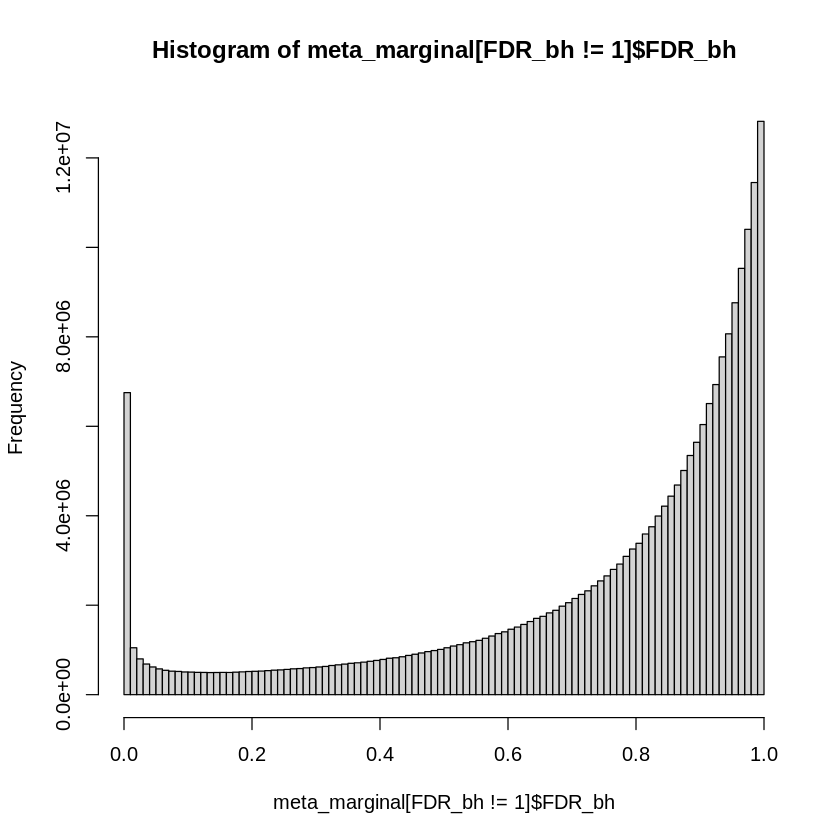

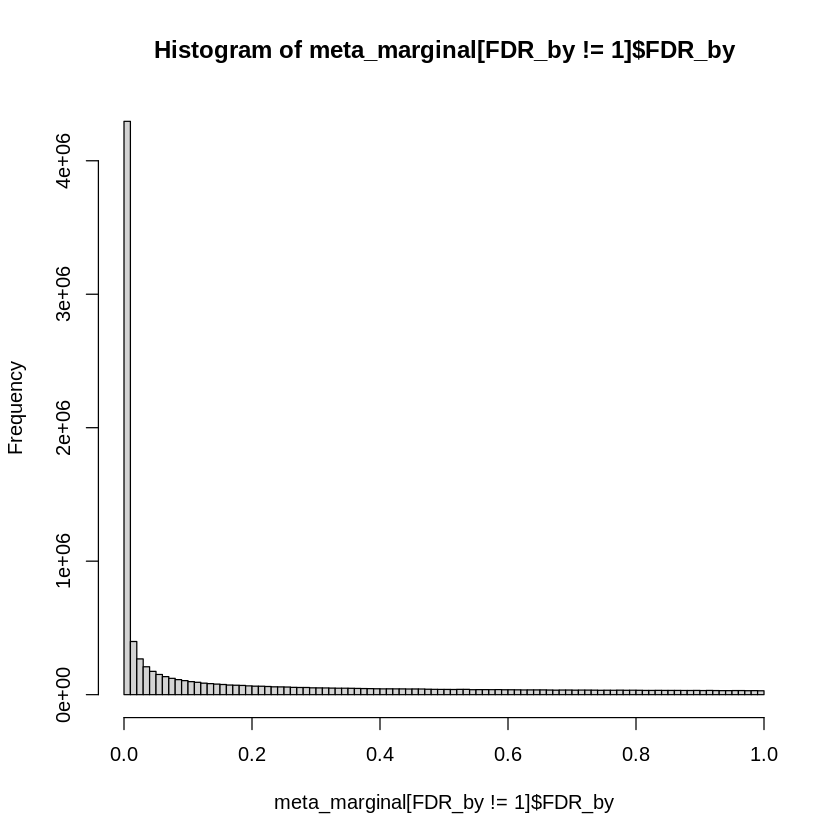

V1,V2,N
<int>,<int>,<int>
2985585,269540,9905296


V1,V2,N
<int>,<int>,<int>
1895838,133837,5345201


V1,V2,N
<int>,<int>,<int>
873387,55484,1844287


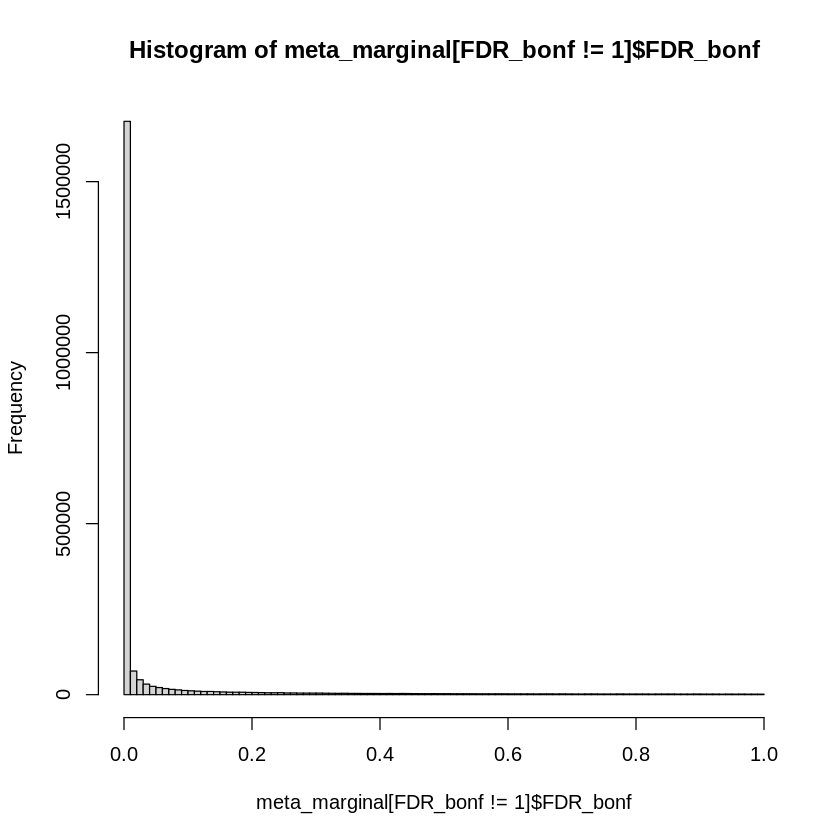

In [11]:
hist(meta_marginal[FDR_bh   != 1]$FDR_bh,breaks=100)
hist(meta_marginal[FDR_by   != 1]$FDR_by,breaks=100)
hist(meta_marginal[FDR_bonf != 1]$FDR_bonf,breaks=100)
meta_marginal[FDR_bh   < 0.05,.(uniqueN(SNP),uniqueN(Probe),.N)]
meta_marginal[FDR_by   < 0.05,.(uniqueN(SNP),uniqueN(Probe),.N)]
meta_marginal[FDR_bonf < 0.05,.(uniqueN(SNP),uniqueN(Probe),.N)]

## Testing on sex interaction data
### Staged method

In [3]:
meta_sex_interaction <-fread(here("data", "delahaye_richs_sex_interaction_mecs_maf01.txt.gz"))

meta_sex_interaction_bonf_cpg <- meta_sex_interaction[,.SD[p < (0.05 / .N)],by="Probe"]
meta_sex_interaction_bonf_cpg <- meta_sex_interaction_bonf_cpg[,.SD[which.min(p)],by="Probe"]

[1] 1

Warning message in min(lambda):
“no non-missing arguments to min; returning Inf”
Warning message in max(lambda):
“no non-missing arguments to max; returning -Inf”
Warning message in max(lambda):
“no non-missing arguments to max; returning -Inf”
Warning message in min(lambda):
“no non-missing arguments to min; returning Inf”
Warning message in max(pi0):
“no non-missing arguments to max; returning -Inf”
Warning message in min(pi0):
“no non-missing arguments to min; returning Inf”
Warning message:
“Removed 1 rows containing missing values (geom_segment).”


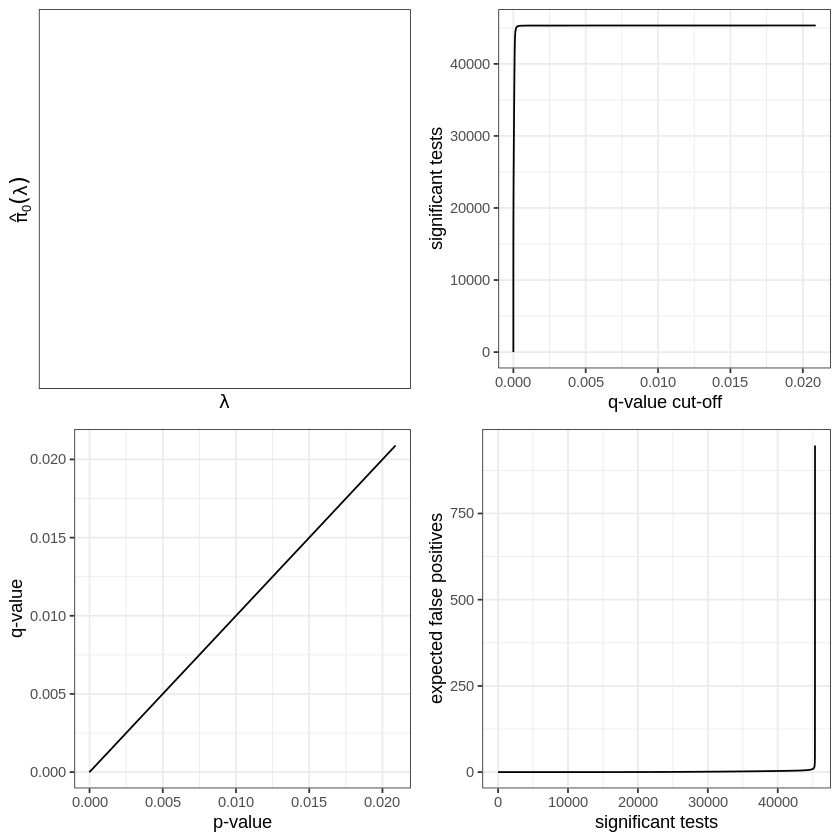

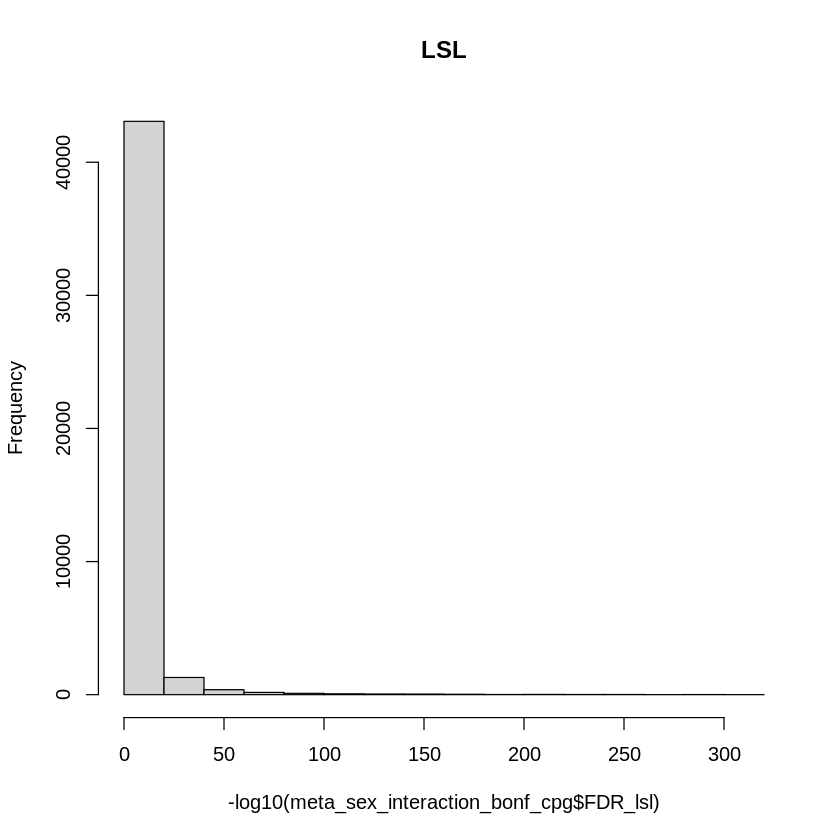

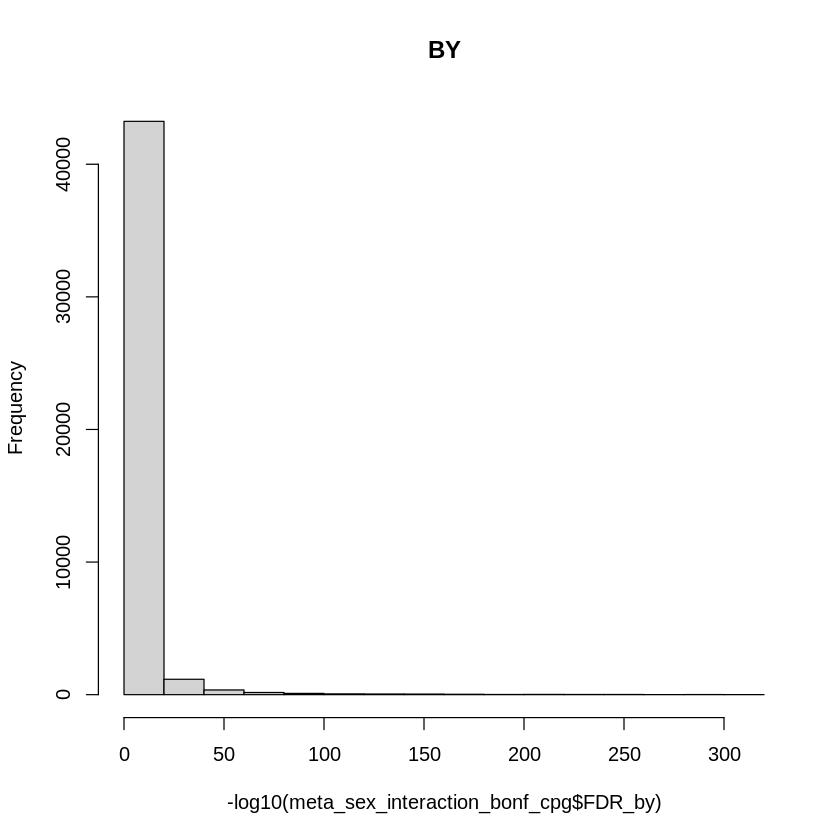

In [4]:
# qval_tst <- qvalue(meta_sex_interaction_bonf_cpg$p,pi0=estimate.pi0(meta_sex_interaction_bonf_cpg$p,method = "tst"))# doesn't work
qval_lsl <- qvalue(meta_sex_interaction_bonf_cpg$p,pi0=estimate.pi0(meta_sex_interaction_bonf_cpg$p,method = "lsl"))

meta_sex_interaction_bonf_cpg$FDR_lsl <- qval_lsl$qvalues
meta_sex_interaction_bonf_cpg$FDR_by <- p.adjust(meta_sex_interaction_bonf_cpg$p,method="BY")

estimate.pi0(meta_sex_interaction_bonf_cpg$p,method = "lsl")

plot(qval_lsl)
hist(-log10(meta_sex_interaction_bonf_cpg$FDR_lsl), main = "LSL")
hist(-log10(meta_sex_interaction_bonf_cpg$FDR_by), main = "BY")

In [5]:
dim(meta_sex_interaction_bonf_cpg)
dim(meta_sex_interaction_bonf_cpg[FDR_lsl < 0.05])
dim(meta_sex_interaction_bonf_cpg[FDR_by < 0.05])
fwrite(meta_sex_interaction_bonf_cpg[FDR_by < 0.05],here("data","meta_sex_interaction_bonf_cpg.txt.gz"),sep='\t',quote=FALSE,row.names=FALSE)

[1] 45333    16

[1] 45333    16

[1] 45322    16

###  Groupwise FDR

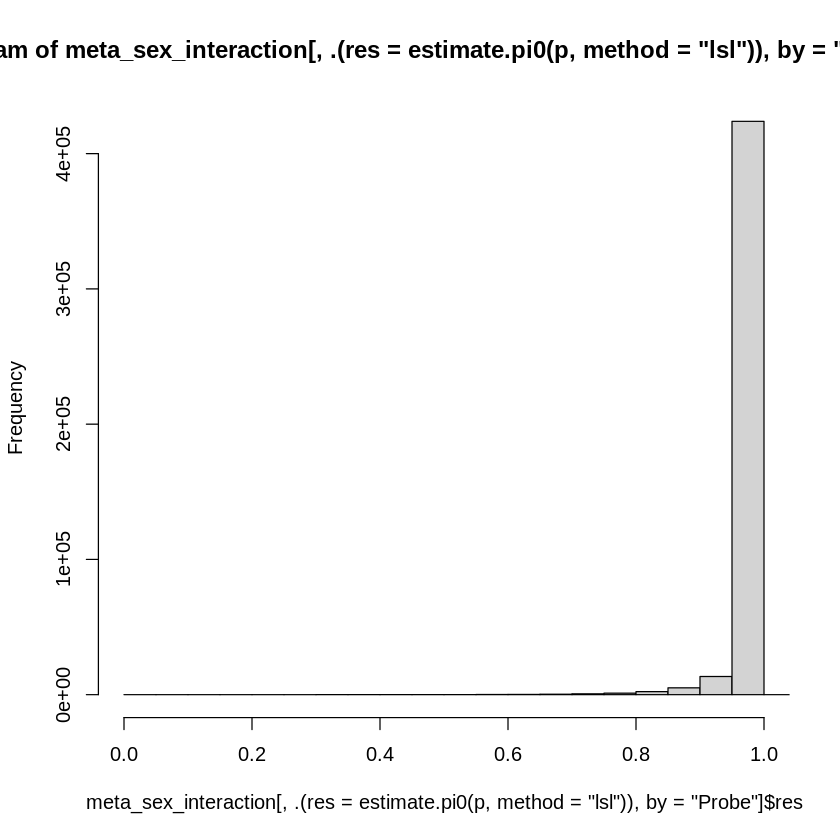

In [6]:
hist(meta_sex_interaction[,.(res=estimate.pi0(p,method='lsl')), by="Probe"]$res,breaks = 100,xlim = c(0,1))

In [10]:
out_int < -adaptiveGBH(meta_sex_interaction, method="lsl", groupcol="Probe")
fwrite(out_int, "tmp_fdr_sex_interaction_meta.csv")

[1] 0.9923597


V1,V2,N
<int>,<int>,<int>
551988,49949,810013


Warning message in hist(-log10(out_int$adjP), xlim = c(0, 1), breaks = 100):
“NaNs produced”


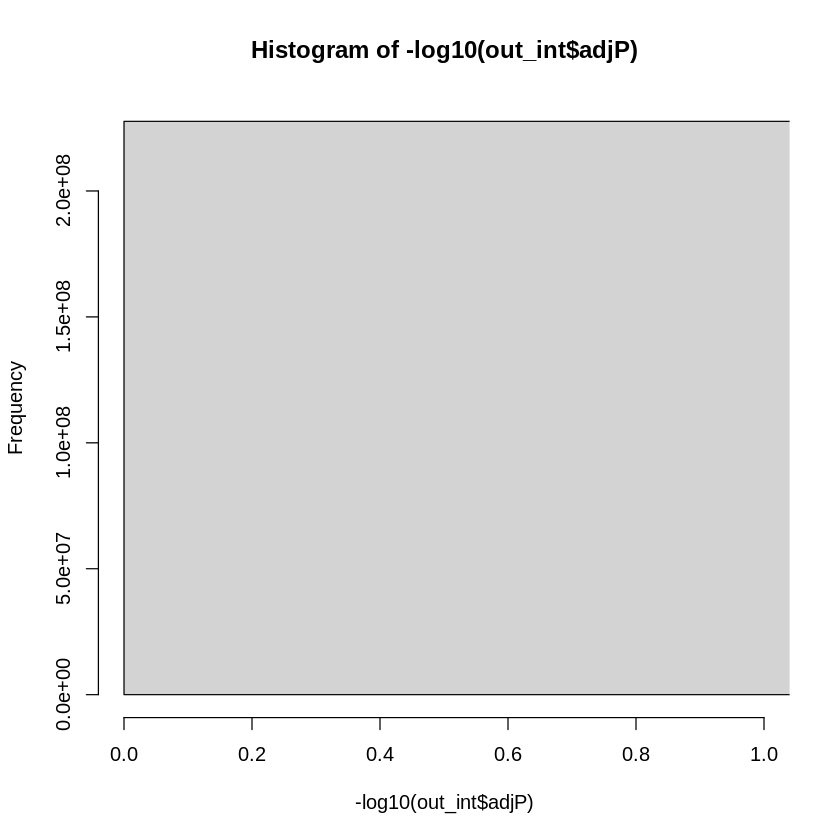

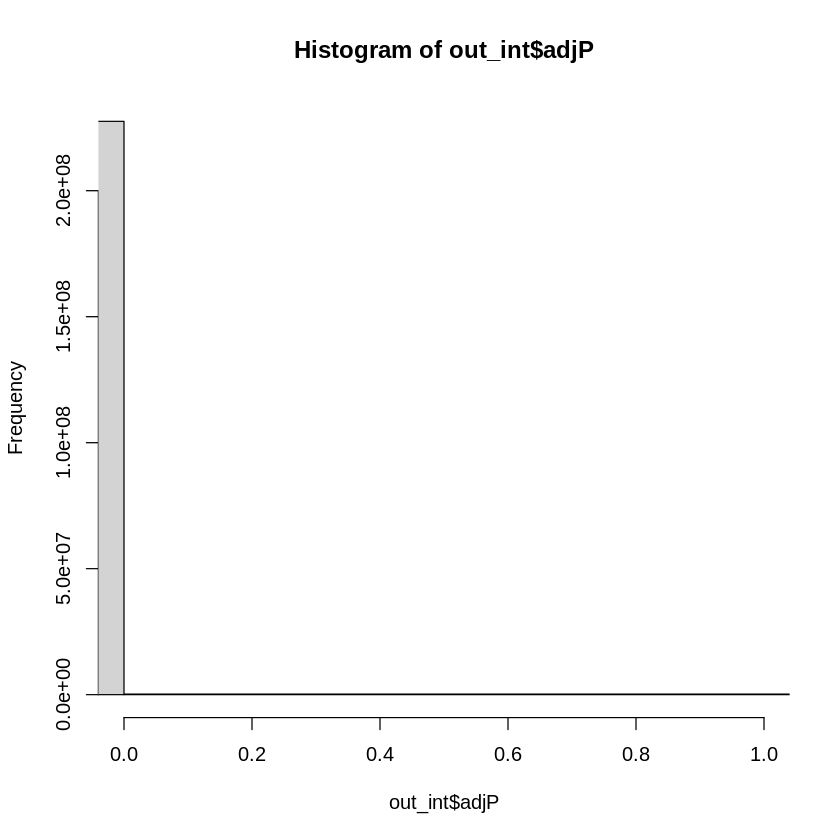

SNP,Chr,BP,A1,A2,Freq,Probe,Probe_Chr,Probe_bp,Gene,Orientation,b,SE,p,pi_g,p_weighted,adjP
<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rs546449139,9,40588084,G,A,0.0101393,cg17491091,9,40633299,cg17491091,-,0,1e+10,1,2.729343,-1.578254,-2746309


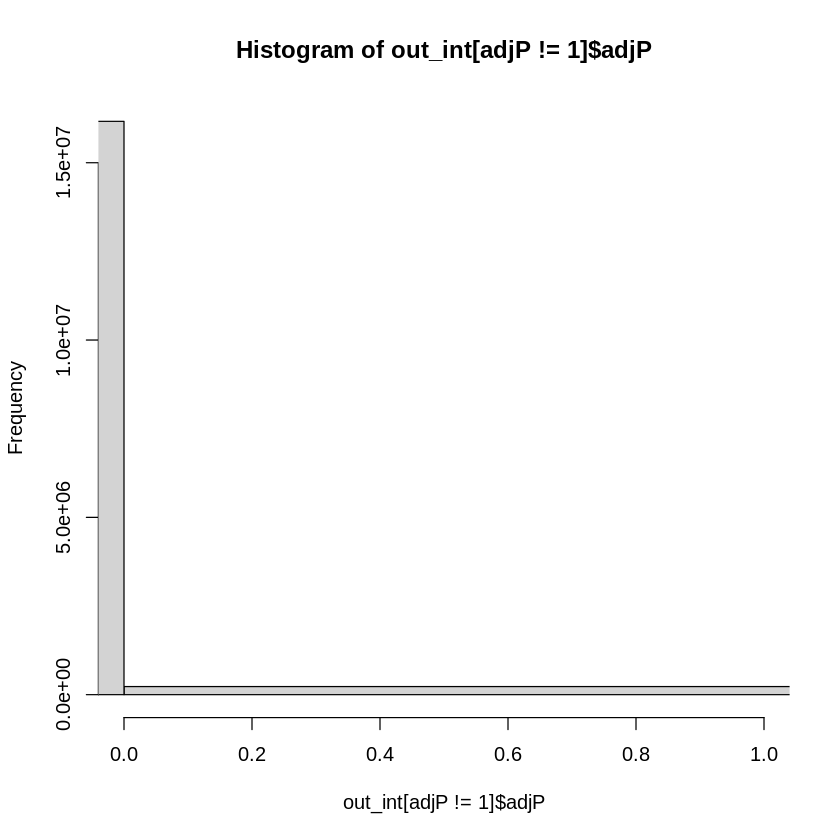

In [14]:
out_int[adjP < 0.05,.(uniqueN(SNP),uniqueN(Probe),.N)]
hist(-log10(out_int$adjP),xlim = c(0,1),breaks=100)
hist(out_int$adjP,breaks=100,xlim = c(0,1))
hist(out_int[adjP != 1]$adjP,breaks=100,xlim = c(0,1))
out_int[adjP < 0.05,.SD[which.max(p)]]

## Point of reference: Flat FDR and Bonferoni Correction


In [12]:
meta_sex_interaction[,`:=`(
    FDR_bh= p.adjust(p,method = "BH"),
    FDR_by= p.adjust(p,method = "BY"),
    FDR_bonf= p.adjust(p,method = "bonf")
)]

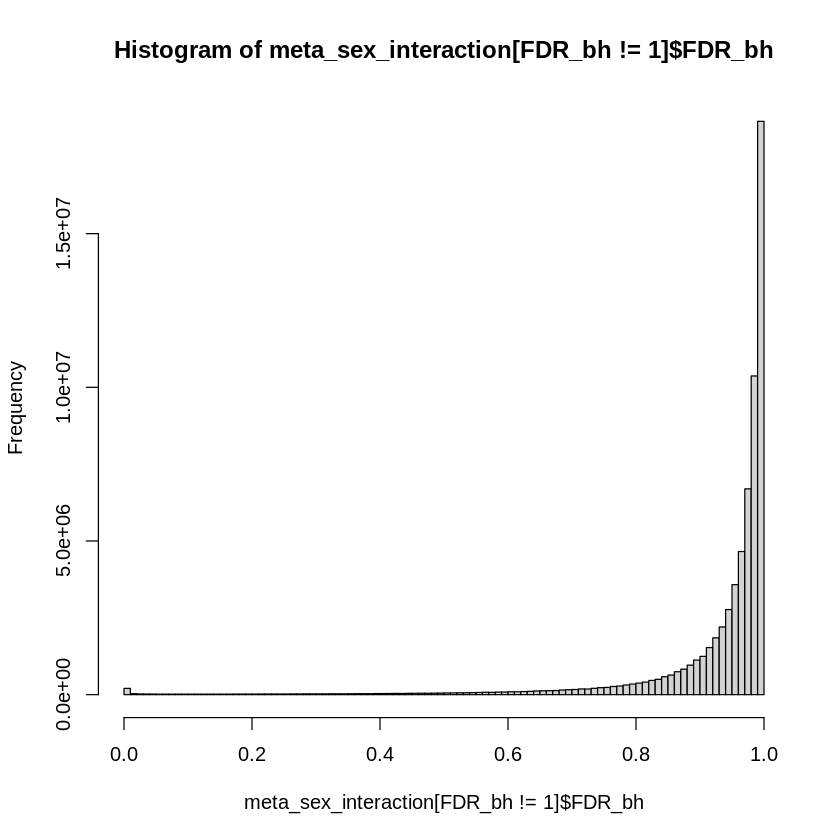

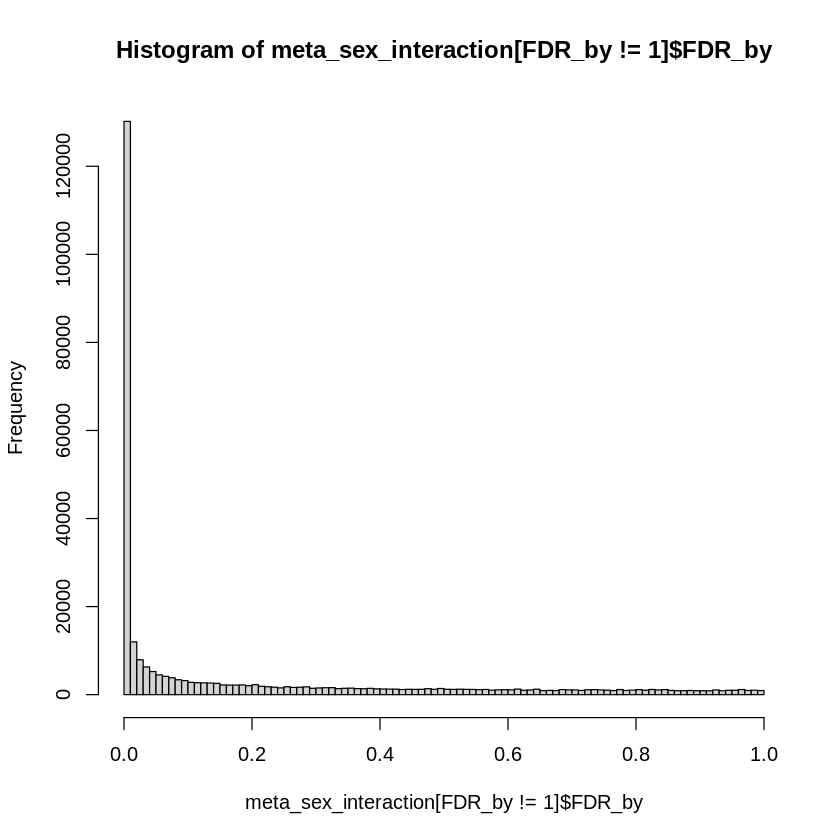

V1,V2,N
<int>,<int>,<int>
206250,39522,301311


V1,V2,N
<int>,<int>,<int>
109740,18322,161656


V1,V2,N
<int>,<int>,<int>
49799,7331,71749


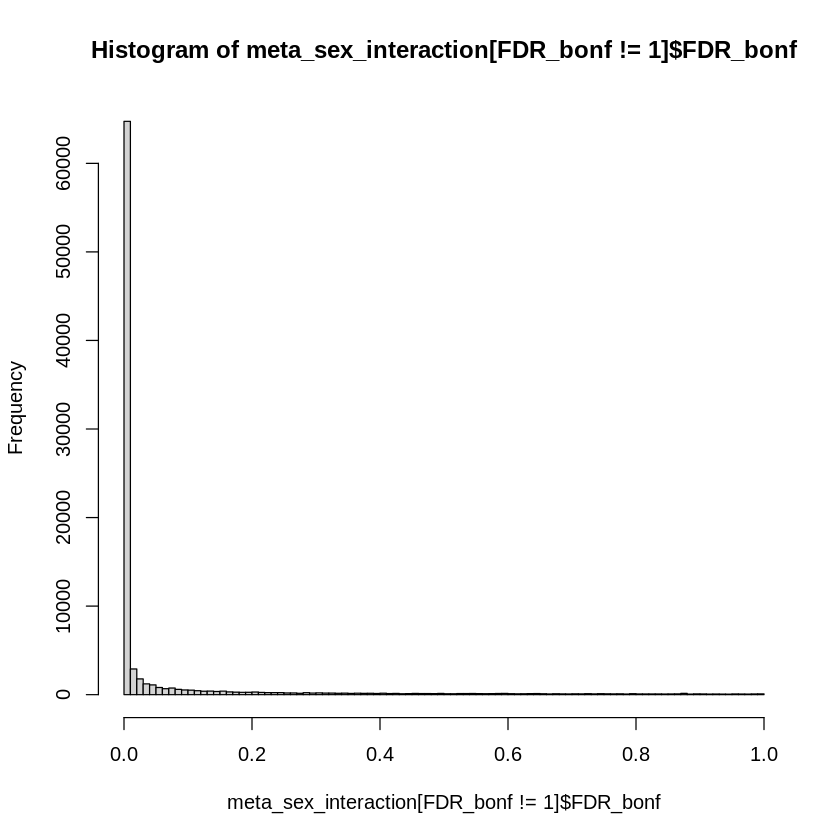

In [13]:
hist(meta_sex_interaction[FDR_bh   != 1]$FDR_bh,breaks=100)
hist(meta_sex_interaction[FDR_by   != 1]$FDR_by,breaks=100)
hist(meta_sex_interaction[FDR_bonf != 1]$FDR_bonf,breaks=100)
meta_sex_interaction[FDR_bh   < 0.05,.(uniqueN(SNP),uniqueN(Probe),.N)]
meta_sex_interaction[FDR_by   < 0.05,.(uniqueN(SNP),uniqueN(Probe),.N)]
meta_sex_interaction[FDR_bonf < 0.05,.(uniqueN(SNP),uniqueN(Probe),.N)]